In [1]:
import gurobipy as gp
from gurobipy import Model, GRB, quicksum
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np
import seaborn as sns
import random

def configure_model(model):
    model.Params.OutputFlag = 0
    model.Params.TimeLimit = 100
    model.Params.MIPGap = 0.05
    model.Params.Presolve = 2
    model.Params.Method = 1         # 让 Gurobi 自选（通常最平衡）
    model.Params.MIPFocus = 1        # 更关注可行解（非全局最优）
    model.Params.Heuristics = 0.8    # 启发式加速
    model.Params.Threads = 8


In [2]:
# 参数
m = 15
K = 5
L_levels = [20, 15, 10, 5, 1]  
E_levels = [13, 28, 38, 45, 120] 
E_PU_max = [8000] * m # limit 650
CPU_capacity = [3000] * m
f_v_levels = [15, 20, 30, 40, 60]
P_idle = [18] * m
P_max = [36] * m
T_total = 300
total_tasks = 100


chain_tasks = {
    0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    1: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
    2: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
    3: [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
    4: [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
    5: [50, 51, 52, 53, 54, 55, 56, 57],
    6: [58, 59, 60],
    7: [61, 62, 63],
    8: [64, 65, 66],
    9: [67, 68, 69],
    10: [70, 71, 72],
    11: [73, 74, 75],
    12: [76, 77, 78],
    13: [79, 80, 81],
    14: [82, 83, 84],
    15: [85, 86, 87],
    16: [88, 89, 90],
    17: [91, 92, 93],
    18: [94, 95, 96],
    19: [97, 98, 99]
}


num_chains = len(chain_tasks)
n = max(max(v) for v in chain_tasks.values()) + 1  # 总任务数
L_max = [len(chain_tasks[k]) * 6.5 for k in chain_tasks]  # 每条链的最大延迟




# L_max = [int(length * 6.5) for length in tasks_per_chain_list]


def configure_model(model):
    model.Params.OutputFlag = 0
    model.Params.TimeLimit = 300
    model.Params.MIPGap = 0.05
    model.Params.MIPFocus = 1
    model.Params.Presolve = 2
    model.Params.Method = 2
    model.Params.Threads = 8

def run_gurobi_model(alpha_1, alpha_2, alpha_3, baseline=False):
    model = gp.Model("MAF_Optimization")
    configure_model(model)
   

    delta = model.addVars(n, vtype=GRB.BINARY, name="delta")
    w = model.addVars(n, m, vtype=GRB.BINARY, name="w")
    y = model.addVars(n, K, vtype=GRB.BINARY, name="y")
    z = model.addVars(num_chains, vtype=GRB.BINARY, name="z")
    E_PU = model.addVars(m, name="E_PU")

    if baseline:
        for i in range(n):
            model.addConstr(y[i, K - 1] == delta[i])
            for k in range(K - 1):
                model.addConstr(y[i, k] == 0)

    for i in range(n):
        model.addConstr(gp.quicksum(w[i, j] for j in range(m)) == delta[i])
        model.addConstr(gp.quicksum(y[i, k] for k in range(K)) == delta[i])
        for k in range(K):
            model.addConstr(y[i, k] <= delta[i])  # ✅ 确保未激活任务 y[i,k] = 0

    for k in range(num_chains):
        model.addConstr(gp.quicksum(delta[i] for i in chain_tasks[k]) == z[k] * len(chain_tasks[k]))
        delay_chain = gp.quicksum(y[i, k_] * L_levels[k_] for i in chain_tasks[k] for k_ in range(K))
        model.addConstr(delay_chain <= L_max[k])


    for j in range(m):
        model.addConstr(
            gp.quicksum(w[i, j] * gp.quicksum(y[i, k] * f_v_levels[k] for k in range(K)) for i in range(n)) <= CPU_capacity[j]
        )
        active_time = gp.quicksum(w[i, j] * gp.quicksum(y[i, k] * L_levels[k] for k in range(K)) for i in range(n))
        U_j = active_time / T_total
        E_PU_expr = P_idle[j] * (T_total - active_time) + (P_max[j] - P_idle[j]) * U_j * T_total
        model.addConstr(E_PU[j] == E_PU_expr)
        model.addConstr(E_PU[j] <= E_PU_max[j])

    total_task_energy = gp.quicksum(y[i, k] * E_levels[k] for i in range(n) for k in range(K))
    total_chain_accept = gp.quicksum(z[k] for k in range(num_chains))
    total_pu_energy = gp.quicksum(E_PU[j] for j in range(m))

    model.setObjective(
        alpha_1 * total_chain_accept - alpha_2 * total_task_energy - alpha_3 * total_pu_energy,
        GRB.MAXIMIZE
    )


    start_time = time.time()
    model.optimize()
    end_time = time.time()
    if model.status != GRB.OPTIMAL:
        print("❌ 模型未成功优化，跳过变量访问")
        return None
    print(f"⏱️ Gurobi 运行时间: {end_time - start_time:.2f} 秒")
    print("\n📋 链激活状态总览：")
    for k in range(num_chains):
        status = "✅ 激活" if z[k].X > 0.5 else "❌ 未激活"
        task_list = chain_tasks[k]
        print(f"链 {k}: {status}, 包含任务: {task_list}")
    
    accepted_chains = [k for k in range(num_chains) if z[k].X > 0.5]
    pu_assignment = [j for i in range(n) for j in range(m) if w[i, j].X > 0.5]
    pu_task_map = {}
    for task_id, pu_id in enumerate(pu_assignment):
         pu_task_map.setdefault(pu_id, []).append(task_id)
    
    task_energy_levels = [max((y[i, k].X, k) for k in range(K))[1] if delta[i].X > 0.5 else -1 for i in range(n)]



    return {
        "模式": "Baseline" if baseline else "Non-Baseline",
        "目标函数值": model.ObjVal,
        "被接受的任务链数": len(accepted_chains),
        "PU 总能耗": sum(E_PU[j].X for j in range(m)),
        "任务总能耗": sum(y[i, k].X * E_levels[k] for i in range(n) for k in range(K)),
        "运行时间": model.Runtime,
        "PU 任务分配": pu_task_map,
        "任务能源等级": task_energy_levels,
        "激活链列表": [1 if z[k].X > 0.5 else 0 for k in range(num_chains)]  # ✅ 新增
    }


In [3]:

import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

def visualize_baseline_vs_optimal_extended_v4(baseline_result, optimal_result, num_chains):
    labels = ["Baseline", "Optimal"]
    colors = ["#5DADE2", "#F5B041"]  # 更柔和的蓝色和橙色

    # 数据提取
    times = [baseline_result["运行时间"], optimal_result["运行时间"]]
    acceptance = [
        baseline_result["被接受的任务链数"] / num_chains,
        optimal_result["被接受的任务链数"] / num_chains
    ]
    total_energy = [
        baseline_result["任务总能耗"] + baseline_result["PU 总能耗"],
        optimal_result["任务总能耗"] + optimal_result["PU 总能耗"]
    ]
    saving_values = [
        0,
        (total_energy[0] - total_energy[1]) / total_energy[0] * 100
    ]

    objective_values = [baseline_result["目标函数值"], optimal_result["目标函数值"]]

    # PU 分配统计
    baseline_pu_counts = {k: len(tasks) for k, tasks in baseline_result["PU 任务分配"].items()}
    optimal_pu_counts = {k: len(tasks) for k, tasks in optimal_result["PU 任务分配"].items()}

    pu_ids = sorted(set(baseline_pu_counts.keys()) | set(optimal_pu_counts.keys()))
    baseline_pu_values = [baseline_pu_counts.get(i, 0) for i in pu_ids]
    optimal_pu_values = [optimal_pu_counts.get(i, 0) for i in pu_ids]

    # 能源等级统计
    baseline_energy_levels = [e for e in baseline_result["任务能源等级"] if e >= 0]
    optimal_energy_levels = [e for e in optimal_result["任务能源等级"] if e >= 0]

    K = max(baseline_energy_levels + optimal_energy_levels) + 1
    energy_levels = list(range(K))

    baseline_energy_counter = Counter(baseline_energy_levels)
    optimal_energy_counter = Counter(optimal_energy_levels)

    baseline_energy_counts = [baseline_energy_counter.get(k, 0) for k in energy_levels]
    optimal_energy_counts = [optimal_energy_counter.get(k, 0) for k in energy_levels]

    # 任务链激活统计
    baseline_chain_activation = baseline_result["激活链列表"]
    optimal_chain_activation = optimal_result["激活链列表"]
    chain_ids = np.arange(1, num_chains + 1)

    fig, axs = plt.subplots(3, 3, figsize=(20, 18))

    # 执行时间
    axs[0, 0].bar(labels, times, color=colors)
    axs[0, 0].set_title("Execution Time (s)")
    for i, v in enumerate(times):
        axs[0, 0].text(i, v, f"{v:.2f}", ha='center', va='bottom')

    # 接受率
    axs[0, 1].bar(labels, acceptance, color=colors)
    axs[0, 1].set_title("Chain Acceptance Rate")
    axs[0, 1].set_ylim(0, 1)
    for i, v in enumerate(acceptance):
        axs[0, 1].text(i, v, f"{v:.1%}", ha='center', va='bottom')

    # 目标函数值对比
    axs[2, 0].bar(labels, objective_values, color=colors)
    axs[2, 0].set_title("Objective Function Comparison")
    for i, v in enumerate(objective_values):
        axs[2, 0].text(i, v, f"{v:.2f}", ha='center', va='bottom')

    # 总能耗
    axs[0, 2].bar(labels, total_energy, color=colors)
    axs[0, 2].set_title("Total Energy Consumption")
    for i, v in enumerate(total_energy):
        axs[0, 2].text(i, v, f"{v:.1f}", ha='center', va='bottom')

    # 节能百分比
    axs[1, 0].bar(labels, saving_values, color=colors)
    axs[1, 0].set_title("Energy Savings Compared to Baseline (%)")
    axs[1, 0].axhline(0, color='black', linewidth=0.8, linestyle='--')
    for i, v in enumerate(saving_values):
        axs[1, 0].text(i, v, f"{v:.2f}%", ha='center', va='bottom')

    # PU 上任务分配
    width = 0.35
    x = np.arange(len(pu_ids))
    axs[1, 1].bar(x - width/2, baseline_pu_values, width=width, label='Baseline', color=colors[0])
    axs[1, 1].bar(x + width/2, optimal_pu_values, width=width, label='Optimal', color=colors[1])
    axs[1, 1].set_title("Task Count per PU")
    axs[1, 1].set_xlabel("PU Index")
    axs[1, 1].set_xticks(x)
    axs[1, 1].set_xticklabels(pu_ids)
    axs[1, 1].legend()
    for i in x:
        axs[1, 1].text(i - width/2, baseline_pu_values[i], baseline_pu_values[i], ha='center', va='bottom')
        axs[1, 1].text(i + width/2, optimal_pu_values[i], optimal_pu_values[i], ha='center', va='bottom')

    # 能源等级分布
    x2 = np.arange(len(energy_levels))
    axs[1, 2].bar(x2 - width/2, baseline_energy_counts, width=width, label='Baseline', color=colors[0])
    axs[1, 2].bar(x2 + width/2, optimal_energy_counts, width=width, label='Optimal', color=colors[1])
    axs[1, 2].set_title("Task Count per Energy Level")
    axs[1, 2].set_xlabel("Energy Level")
    axs[1, 2].set_xticks(x2)
    axs[1, 2].set_xticklabels([str(e + 1) for e in energy_levels])
    axs[1, 2].legend()
    for i in x2:
        axs[1, 2].text(i - width/2, baseline_energy_counts[i], baseline_energy_counts[i], ha='center', va='bottom')
        axs[1, 2].text(i + width/2, optimal_energy_counts[i], optimal_energy_counts[i], ha='center', va='bottom')


    # 任务链激活情况对比 (Baseline)
    axs[2, 1].bar(chain_ids, baseline_chain_activation, color=colors[0])
    axs[2, 1].set_title("Chain Activation - Baseline")
    axs[2, 1].set_xlabel("Chain ID")
    axs[2, 1].set_ylabel("Activated (1) or Not (0)")

    # 任务链激活情况对比 (Optimal)
    axs[2, 2].bar(chain_ids, optimal_chain_activation, color=colors[1])
    axs[2, 2].set_title("Chain Activation - Optimal")
    axs[2, 2].set_xlabel("Chain ID")
    axs[2, 2].set_ylabel("Activated (1) or Not (0)")

    fig.tight_layout()
    plt.show()






Set parameter Username
Set parameter LicenseID to value 2599825
Academic license - for non-commercial use only - expires 2025-12-16
⏱️ Gurobi 运行时间: 0.08 秒

📋 链激活状态总览：
链 0: ✅ 激活, 包含任务: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
链 1: ✅ 激活, 包含任务: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
链 2: ✅ 激活, 包含任务: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
链 3: ✅ 激活, 包含任务: [30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
链 4: ✅ 激活, 包含任务: [40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
链 5: ✅ 激活, 包含任务: [50, 51, 52, 53, 54, 55, 56, 57]
链 6: ✅ 激活, 包含任务: [58, 59, 60]
链 7: ✅ 激活, 包含任务: [61, 62, 63]
链 8: ✅ 激活, 包含任务: [64, 65, 66]
链 9: ✅ 激活, 包含任务: [67, 68, 69]
链 10: ✅ 激活, 包含任务: [70, 71, 72]
链 11: ✅ 激活, 包含任务: [73, 74, 75]
链 12: ✅ 激活, 包含任务: [76, 77, 78]
链 13: ✅ 激活, 包含任务: [79, 80, 81]
链 14: ✅ 激活, 包含任务: [82, 83, 84]
链 15: ✅ 激活, 包含任务: [85, 86, 87]
链 16: ✅ 激活, 包含任务: [88, 89, 90]
链 17: ✅ 激活, 包含任务: [91, 92, 93]
链 18: ✅ 激活, 包含任务: [94, 95, 96]
链 19: ✅ 激活, 包含任务: [97, 98, 99]
⏱️ Gurobi 运行时间: 0.33 秒

📋 链激活状态总览：
链 0: ✅ 激活, 包含任务: [0, 1, 2, 3, 4, 5, 6,

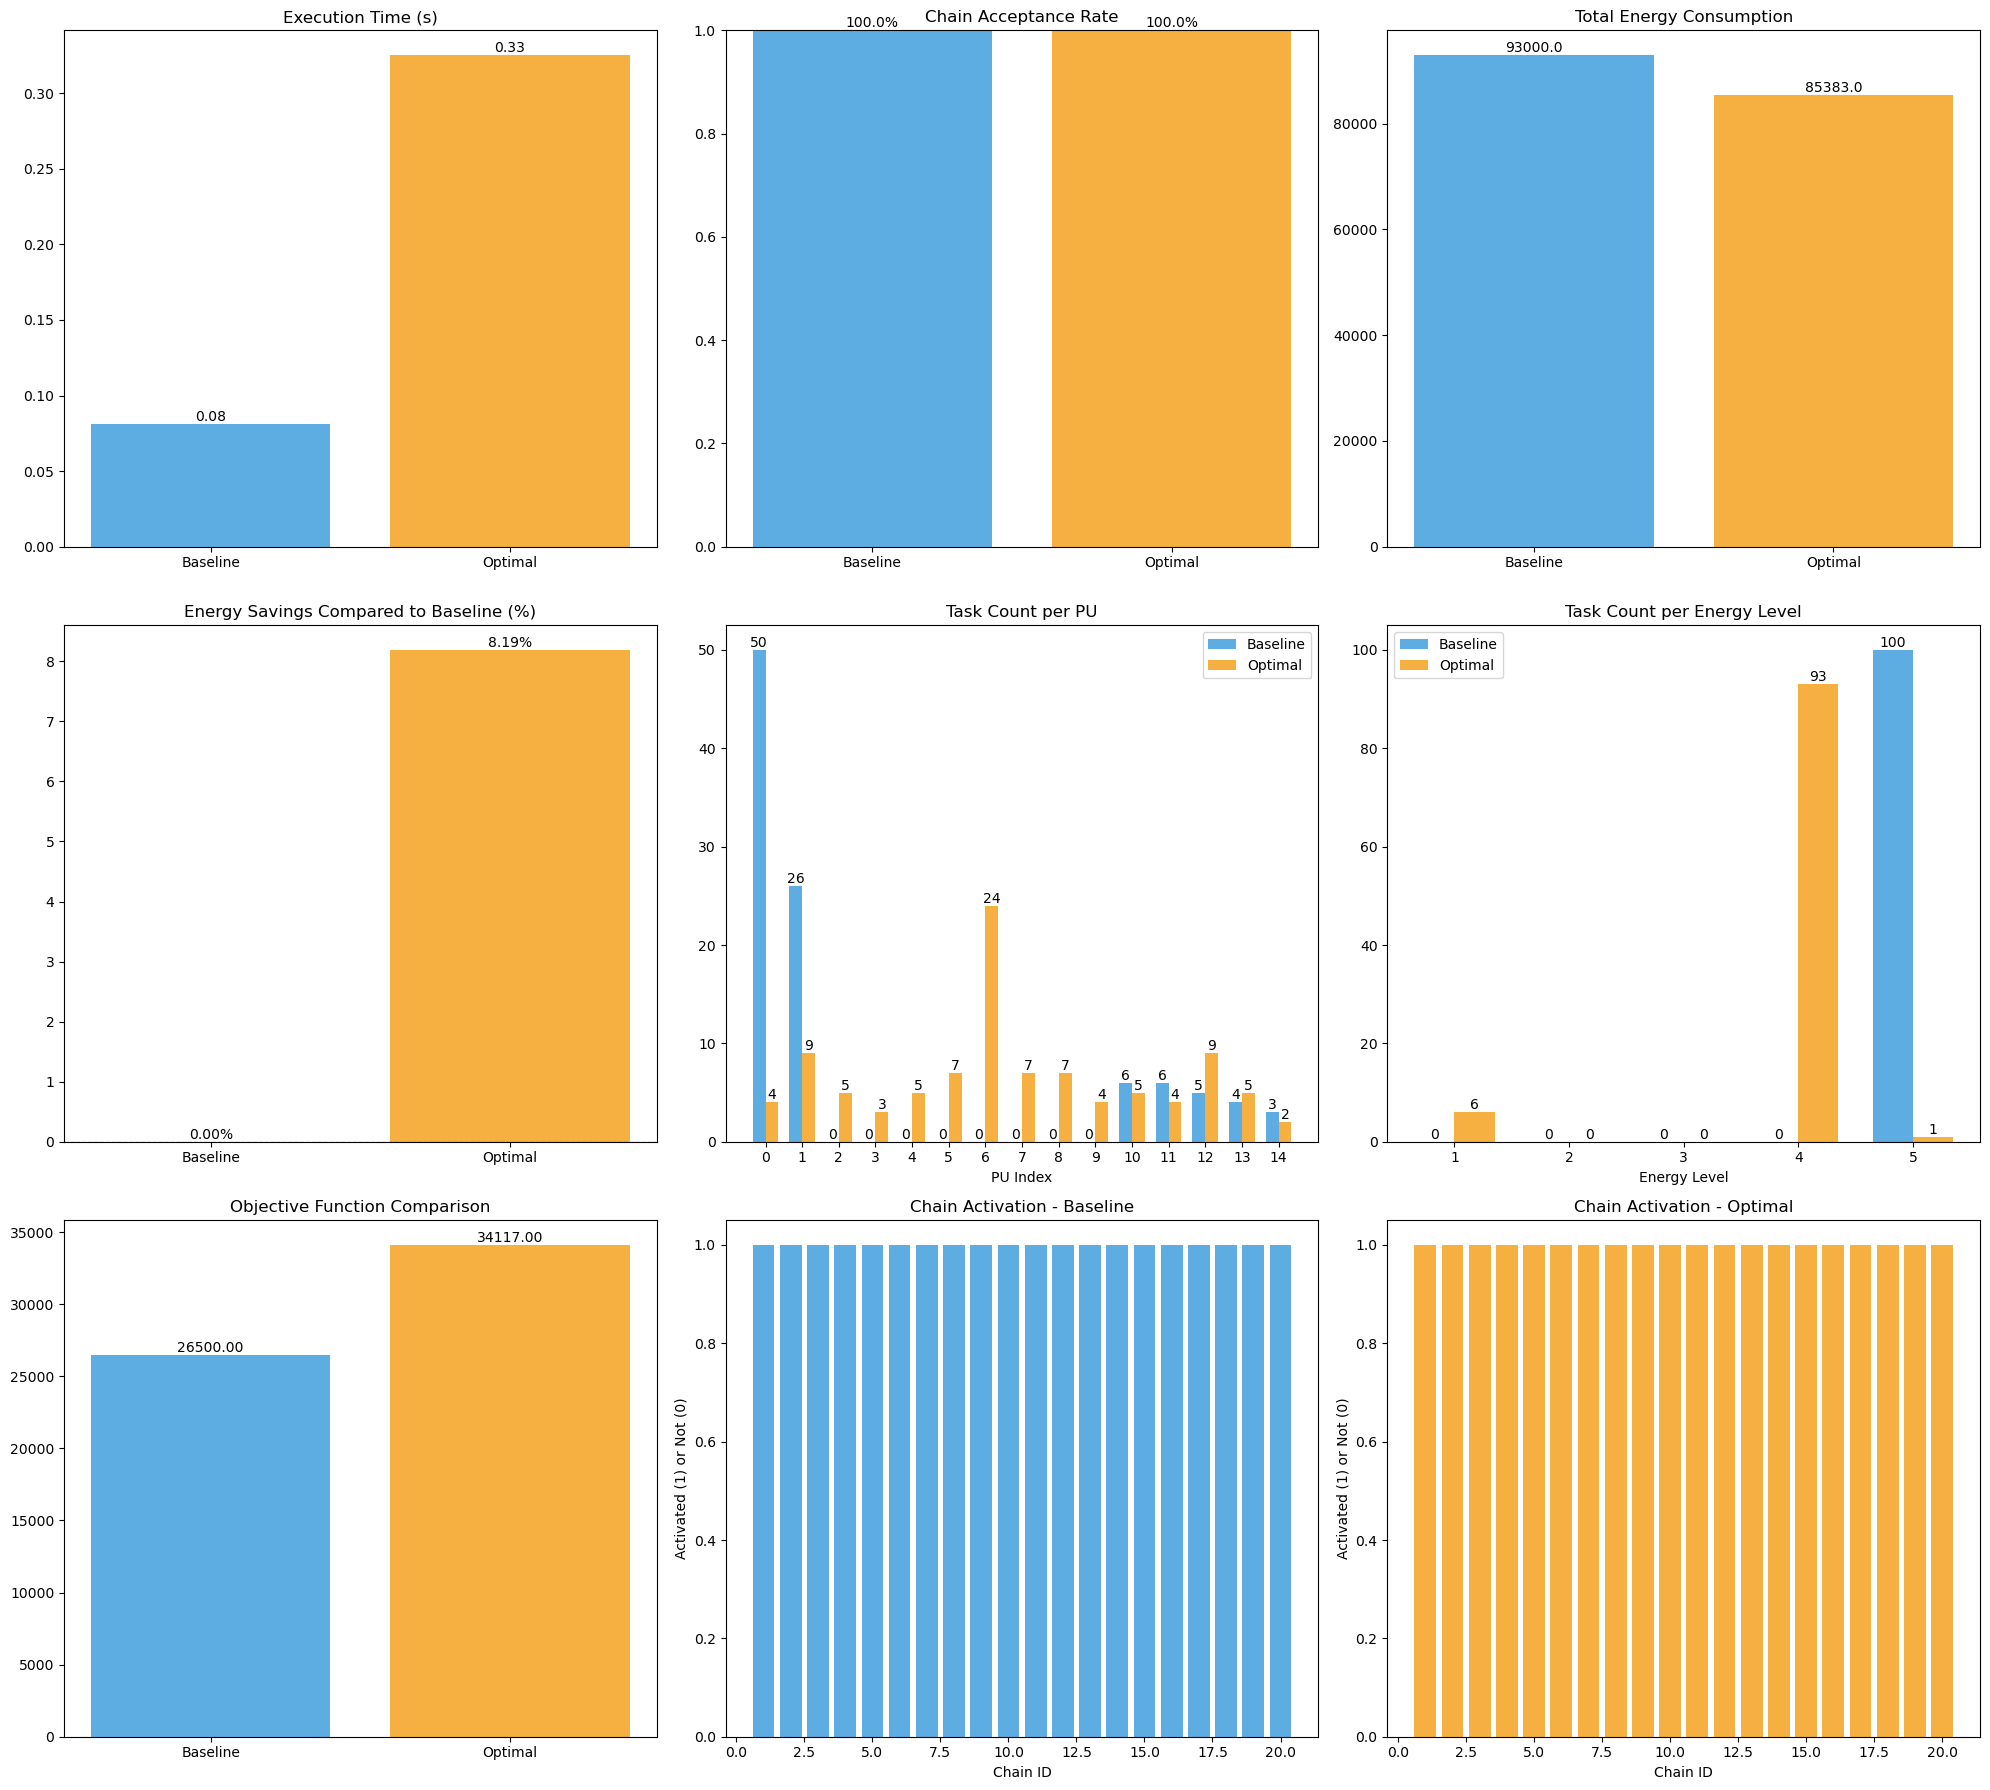

In [4]:
baseline_result = run_gurobi_model(alpha_1=8000, alpha_2=1, alpha_3=1.5, baseline=True)
optimal_result  = run_gurobi_model(alpha_1=8000, alpha_2=1, alpha_3=1.5, baseline=False)

visualize_baseline_vs_optimal_extended_v4(baseline_result, optimal_result, num_chains)


⏱️ Gurobi 运行时间: 0.10 秒

📋 链激活状态总览：
链 0: ❌ 未激活, 包含任务: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
链 1: ❌ 未激活, 包含任务: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
链 2: ❌ 未激活, 包含任务: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
链 3: ❌ 未激活, 包含任务: [30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
链 4: ❌ 未激活, 包含任务: [40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
链 5: ❌ 未激活, 包含任务: [50, 51, 52, 53, 54, 55, 56, 57]
链 6: ✅ 激活, 包含任务: [58, 59, 60]
链 7: ✅ 激活, 包含任务: [61, 62, 63]
链 8: ✅ 激活, 包含任务: [64, 65, 66]
链 9: ✅ 激活, 包含任务: [67, 68, 69]
链 10: ✅ 激活, 包含任务: [70, 71, 72]
链 11: ✅ 激活, 包含任务: [73, 74, 75]
链 12: ✅ 激活, 包含任务: [76, 77, 78]
链 13: ✅ 激活, 包含任务: [79, 80, 81]
链 14: ✅ 激活, 包含任务: [82, 83, 84]
链 15: ✅ 激活, 包含任务: [85, 86, 87]
链 16: ✅ 激活, 包含任务: [88, 89, 90]
链 17: ✅ 激活, 包含任务: [91, 92, 93]
链 18: ✅ 激活, 包含任务: [94, 95, 96]
链 19: ✅ 激活, 包含任务: [97, 98, 99]
⏱️ Gurobi 运行时间: 0.30 秒

📋 链激活状态总览：
链 0: ❌ 未激活, 包含任务: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
链 1: ❌ 未激活, 包含任务: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
链 2: ❌ 未激活, 包含任务: [20, 21, 22, 23, 24, 25, 26, 27, 28, 2

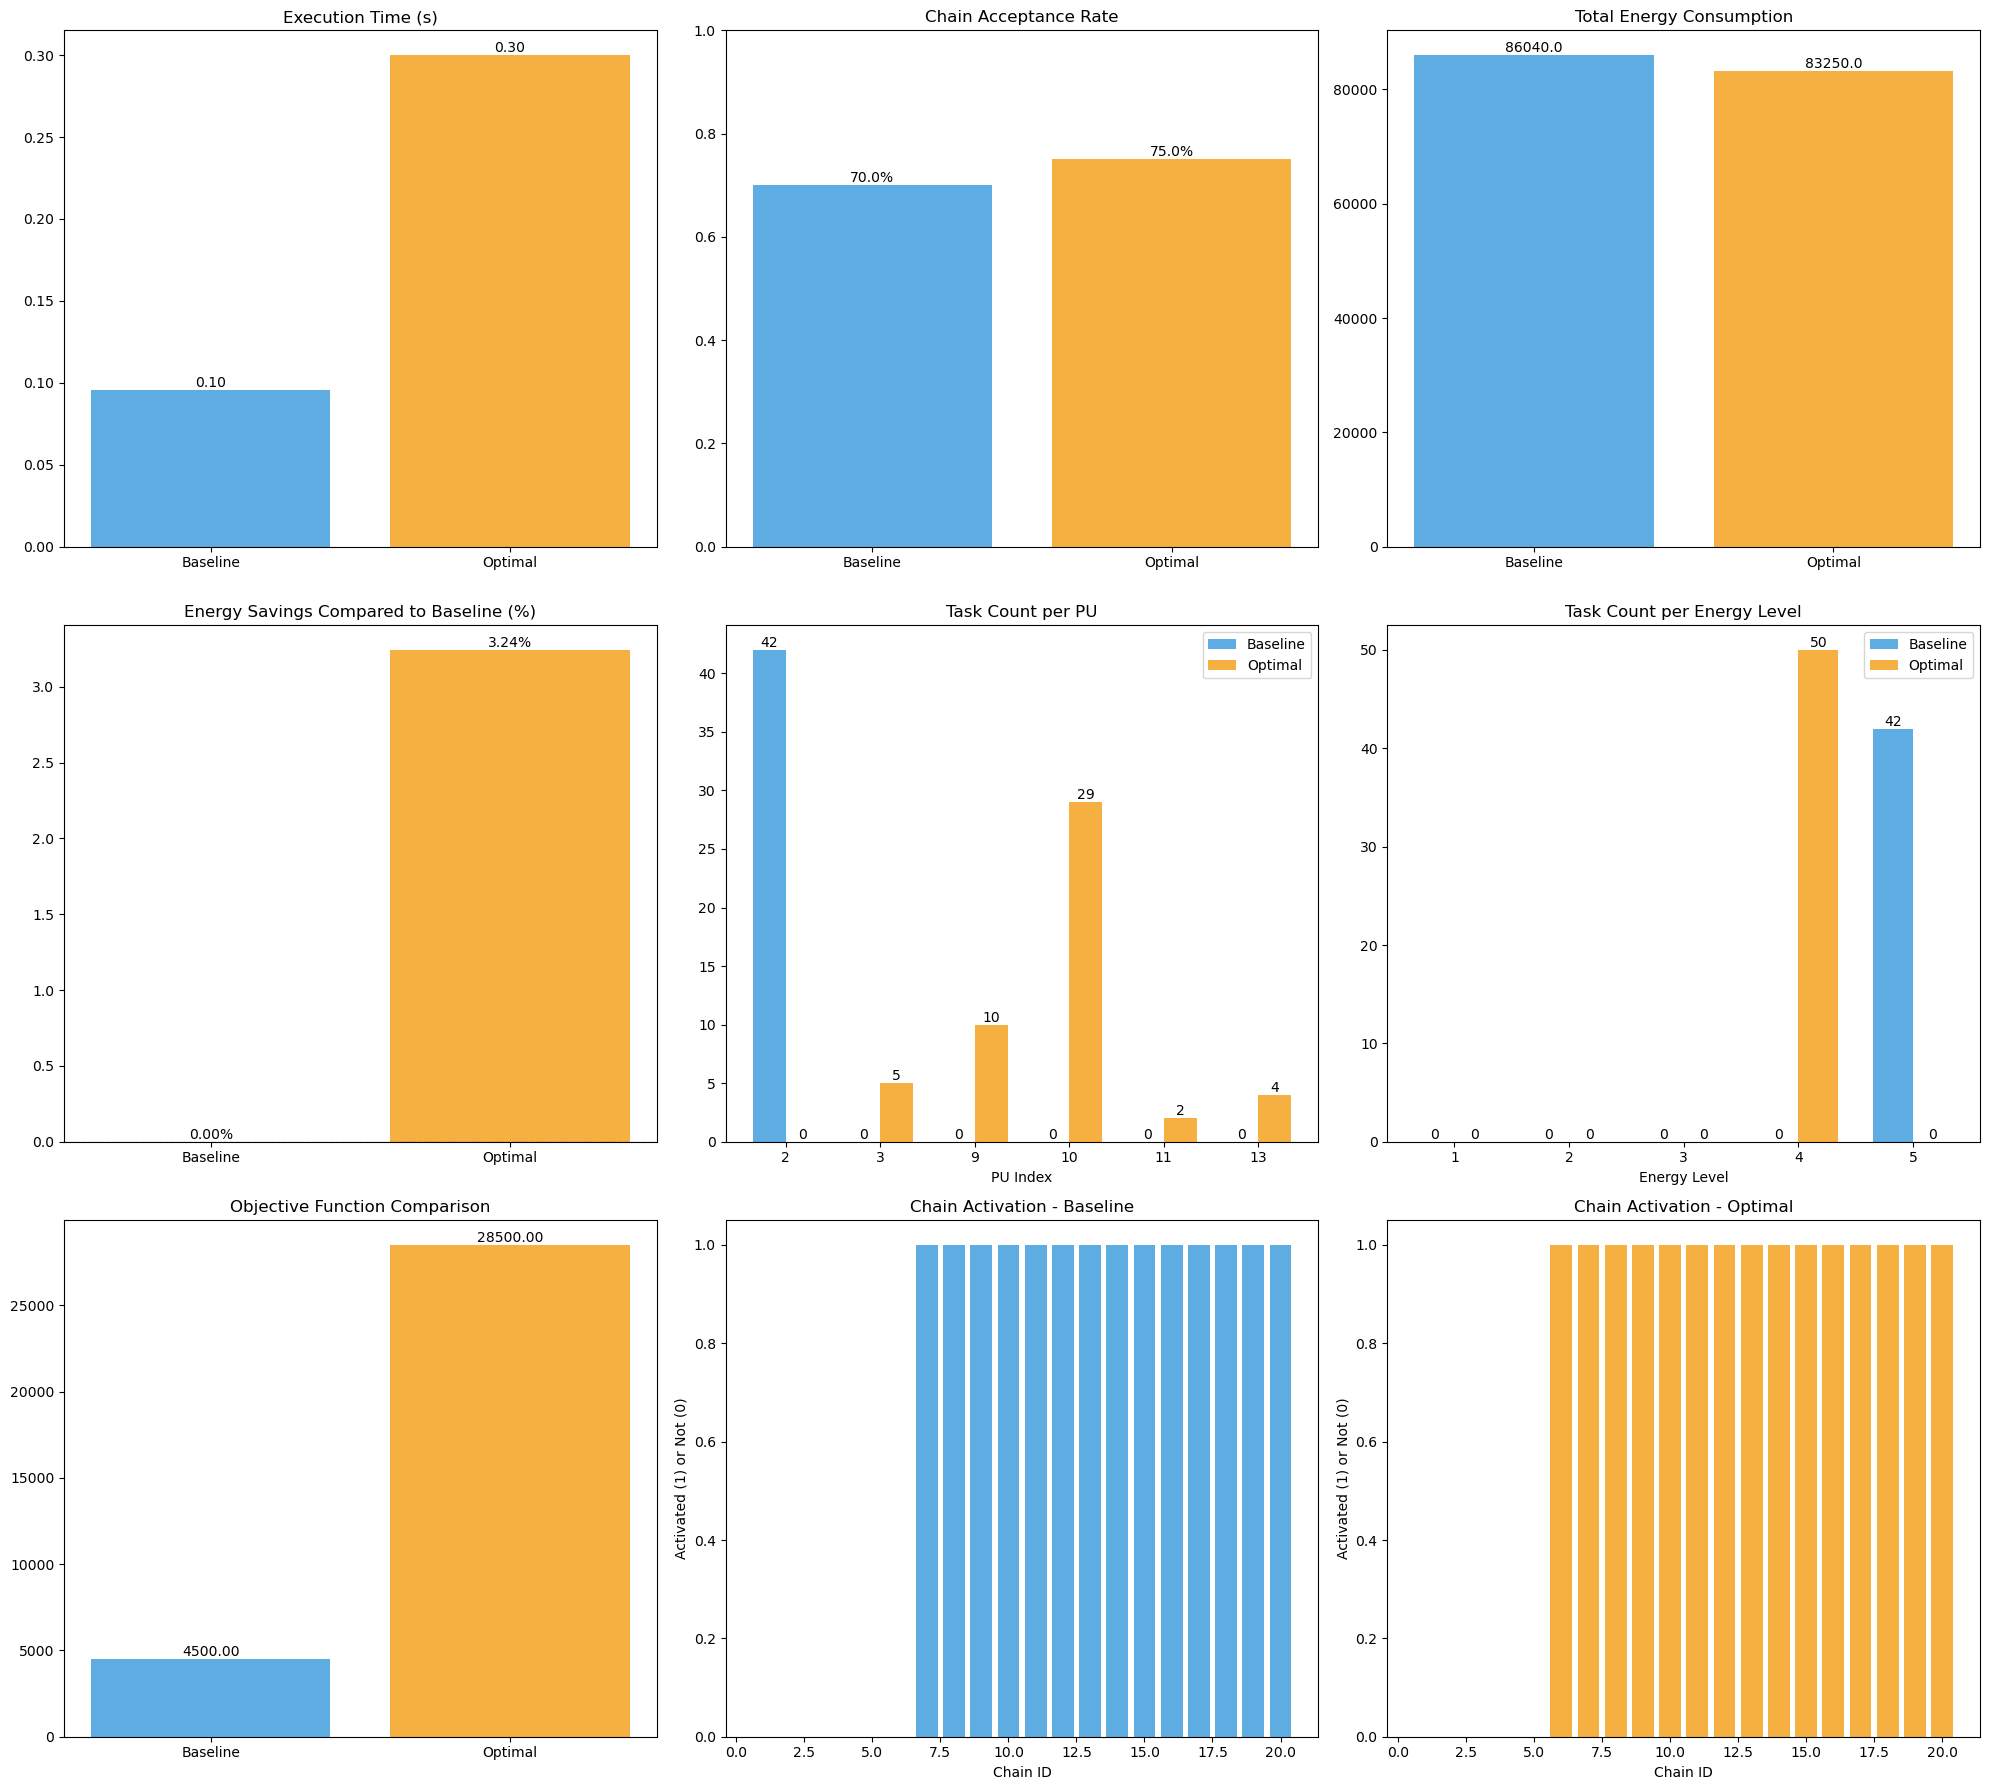

In [12]:
baseline_result = run_gurobi_model(alpha_1=18000, alpha_2=25, alpha_3=1.5, baseline=True)
optimal_result  = run_gurobi_model(alpha_1=16000, alpha_2=40, alpha_3=1.5, baseline=False)

visualize_baseline_vs_optimal_extended_v4(baseline_result, optimal_result, num_chains)